#Adaptive Neurostimulation with Epileptor, Reinforcement Learning

This program will use real-time LFP data from the Epileptor model to find the ideal parameters for
neurostimulation. The state space will be composed of a discretized (partitioned) set of state variables 
acquired from the analysis of the LFP signals. The action space will be a discrete set of amplitudes and 
frequencies. The reward function will include seizure indicators and a negative term for power use.

In [2]:
%pylab nbagg
from tvb.simulator.lab import *


Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


I have created a library with a few very useful functions for The Virtual Brain. This can be found in sim.py.

In [3]:
import sim

#Extracting Features from LFP
Here's some code to extract a few features (mean, min/max, range, power) from an LFP signal.
The first ~2000 ms of the LFP data should be cropped prior to being sent to this function.

In [4]:
def extract_features(raw_time, raw_data):
    data_min = np.min(raw_data[:],0)[0]
    data_max = np.max(raw_data[:],0)[0]
    data_rng = data_max - data_min
    data_avg = np.mean(raw_data[:], 0)[0]
    return (data_min, data_max, data_rng, data_avg)

#Set up the Q-learning algorithm

First, we need to decide on the states we have:
In the case where only [9] is epileptic

    -3 < mins < 1
    -1 < maxs < 3
     0 < rng  < 4
    -2 < avg  < 2
     0 < pwr  < dt * max_amp**2 = 10 * 400
    
So, for now, let's split each into two and get 16 states.
Use a 4-dimensional vector, where 0 indicates the lower values
and 1 indicates higher values.

*Note: for ease of coding, I started with a modified state
vector with only 6 possible states based on averages*

For actions, let's use these:

    0: 0 amp, 0 pulse width
    1: 1 amp, 2.5 p.w., 5 period
    2: 1 amp, 5 p.w., 10 period
    3: 5 amp, 10 p.w., 10 period

For rewards, I did some arbitrary things. The main assumption
here was that:

    (avg < 0) == seizure

Also, I didn't set the negative stimulation reward to be proportional
to power because I don't think that's true. But I'm also not
a neuroscientist.

General parameters for Q-learning are:

    gamma = greediness, ~1 is not greedy
    alpha = learning rate, ~0.2 for now
    epsilon = likelihood to do random things! ~0.1
    
This has been rather useful:
https://studywolf.wordpress.com/2012/11/25/reinforcement-learning-q-learning-and-exploration/

In [5]:
gamma = 0.9
alpha = 0.2
epsilon = 0.1
q_table = {}
actions = [0, 1, 2, 3]

In [6]:
def state_variable_complicated(region, features):
    s_vector = np.zeros((4,1))
    
    #minimum
    if features[0][region][0] < -1:
        s_vector[0] = 0
    else:
        s_vector[0] = 1
        
    #maximum 
    if features[1][region][0] < 1:
        s_vector[1] = 0
    else:
        s_vector[1] = 1
    
    #average
    if features[2][region][0] < 0:
        s_vector[2] = 0
    else: 
        s_vector[2] = 1
        
    #stimulus weight 
    if features[3] == 0:
        s_vector[3] = 0
    else:
        s_vector[3] = 1
    return s_vector
    

Simplified state vector using only average - this will be easier to code for now as it 
gives a total of only 6 states.

In [7]:
def state_vector(region, features):
    s_vector = [0,0]
    if features[2][region][0] < 1:
        s_vector[0] = 0
    elif features[2][region][0] < 0:
        s_vector[0] = 1
    elif features[2][region][0] < 1:
        s_vector[0] = 2
    else:
        s_vector[0] = 3
        
    power = features[4] * features[3]**2 #time * amp^2
    
    
    #for actions above, power is 0, 5 or 250
    
    if power == 0:
        s_vector[1] = 0
    elif power <= 5:
        s_vector[1] = 1
    else:
        s_vector[1] = 2
        
    return (s_vector[0])

Reward function for a given state

In [8]:
def get_reward(s_vector, action):
    
    #seizure is -100 reward
    if  s_vector[0] == 0:
        reward = -100
    else:
        reward = 0
    
    #power reward proportional to negative power 
    if action == 0:
        reward += 0
    elif action == 1 or action == 2:
        reward -= 50  * 0.4 #arbitrary!
    elif action == 3:
        reward -= 250 * 0.4
        
    return reward

Some functions to get, update, and learn the q values of state-action pairs

In [9]:
def get_q(s_vector, action):
    return q_table.get((s_vector, action), 0)
    
def update_q(s_vector, action, newval):
    q_table[(s_vector,action)] = newval

def learn_from_experience(s_1, action, s_2, reward):
    oldval = get_q(s_1, action)
    
    maxq_newstate = max([get_q(s_2, a) for a in actions]) # = V(s') 
    
    # Q(s,a) <- Q(s,a) + alpha * [reward + gamma * V(s') - Q(s,a)]
    
    newval = oldval + alpha * (get_reward(s_2) + gamma * maxq_newstate - oldval)
    #should it be different for the first try??
    
    update_q(s_1, action, newval)
    
    

So now, we can tackle the action choosing problem.

In [10]:
def choose_action(state):
    if random.random() < epsilon:
        action = random.choice(actions)
   
    else:
        q = [get_q(state, a) for a in actions]
        max_q = max(q)
        count = q.count(max_q)
        if count == 1:
            i = q.index(max_q)
        else:
            best_acts = [i for i in range(len(actions)) if q[i] == max_q]
            i = random.choice(best_acts)
        action = actions[i]
    
    return action

Interface between action and stimulus parameters. As described above:

    0: 0 amp, 0 pulse width
    1: 1 amp, 2.5 p.w., 5 period
    2: 1 amp, 5 p.w., 10 period
    3: 5 amp, 10 p.w., 10 period

In [11]:
def set_stim_parameters(action, stim):
    if action == 0:
        stim.temporal.parameters["amp"] = 0
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 0
        
    elif action == 1:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5
        
    elif action == 2:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 5
        
    elif action == 3:
        stim.temporal.parameters["amp"] = 5
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 10
        
        

#Set up test simulation
Just set one epileptic region for now, for simplicity

In [12]:
epileptic = [9]
almost_epileptic = []
stimulus_target = [9]
stimulus_amplitude = 20
stimulus_weight = 2 #0-2 for each region
onset = 0
period = 500
pulse_width = 0
sim_time = 10000
dt = 10

(s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
              stimulus_weight, onset, period, pulse_width, sim_time)

WARNING  File 'hemispheres' not found in ZIP.


This is useful to get rid of the noisy initial conditions - just discard the first 3000 seconds

In [13]:
s.run(simulation_length=3000)
print("")

#Adaptive Loop
Loop through the simulation, fixing stimulation parameters at every iteration

In [16]:
(tt, aa), (xx, xy), (yy, yx) = s.run(simulation_length = 10) #i'm doing this because i'm too lazy to properly initialize the array
i = 0
mins, maxs, rng, avg = [], [], [], []
for i in range(76):
    mins.append([])
    maxs.append([])
    rng.append([])
    avg.append([])

    
states = []
action_log = []
action = 0
    
for i in range(1000):
    
    if i%100 == 0:
        print "\ntime is: " + str(i*10)
    
    (t, a), (x1, x2), (y1, y2) = s.run(simulation_length = dt)
    
    
    #extract_features should be edited later so we just have one tuple
    (imins, imaxs, irng, iavg) = extract_features(t,a)
    features = (imins, imaxs, iavg, stimulus.temporal.parameters["amp"], 
                (dt/stimulus.temporal.parameters["T"])*stimulus.temporal.parameters["tau"]) 
                #amount of time stimulated per dt
    
    states.append( state_vector(9, features) )
    
    if i > 1:
        learn_from_experience(states[i-1], action, states[i], get_reward(states[i], action_log[i-1]))
    
    action = choose_action(states[i])
    action_log.append(action)
    
    set_stim_parameters(action, stimulus)
    
    
    
    length = len(tt)
    for i in range(len(t)):
        tt = np.append(t, tt, axis=0)
        aa = np.append(a, aa, axis=0)
    
    for c in range(76):
        mins[c].append(imins[c])
        maxs[c].append(imaxs[c])
        rng[c].append(irng[c])
        avg[c].append(iavg[c])



time is: 0


TypeError: 'int' object has no attribute '__getitem__'

#Plot results

WARNING  File 'hemispheres' not found in ZIP.


<IPython.core.display.Javascript object>


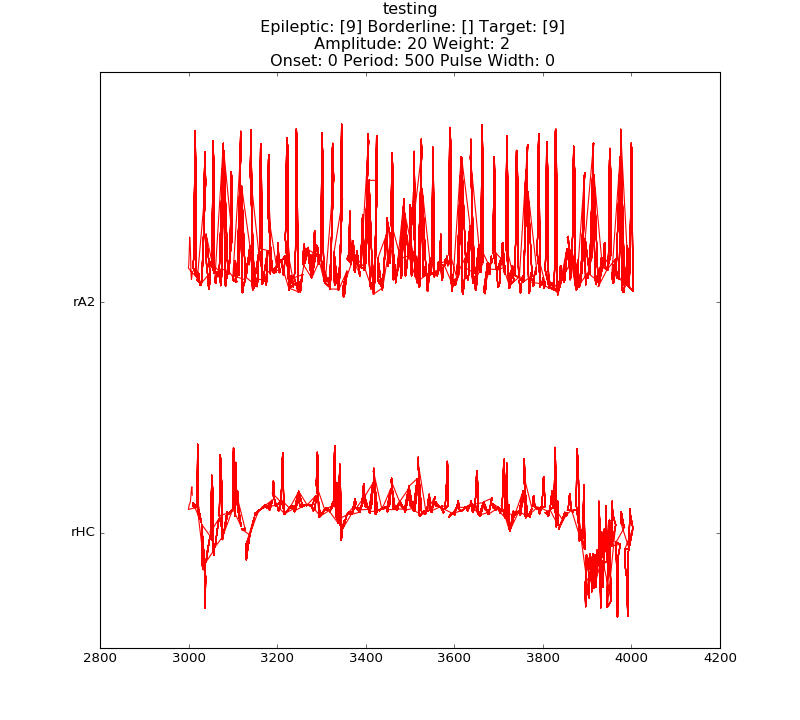

In [14]:
sim.normalize_plot_tavg(tt,aa, [9,1], "testing", epileptic, almost_epileptic, 
                    stimulus_target, stimulus_amplitude, stimulus_weight,
                    onset, period, pulse_width)

In [15]:
states

[(1, 0),
 (1, 2),
 (0, 1),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 2),
 (0, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 2),
 (0, 1),
 (1, 2),
 (0, 1),
 (1, 2)]

# FFT 
FFT might be useful to extract some features. Here's some code to do that

<IPython.core.display.Javascript object>


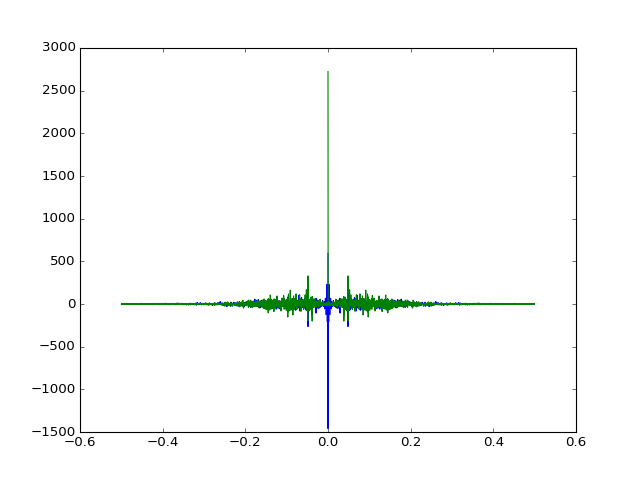

In [34]:
def extract_fft(d):
    
    fd = []
    for i in range(76):
        fd.append([])
    
    for dt in d:
        i = 0
        for region in dt[0]:
            fd[i].append(region[0])
            i += 1
        
    data_fft = []
    for region in fd:
        data_fft.append(fft.fft(region))
        
    return data_fft

plot_times = []
indicators = []
i = 0

for i in range(76):
    plot_times.append(np.fft.fftfreq(3000))



fft_data = extract_fft(taraw[2000:])
plot(plot_times[9], fft_data[9], plot_times[1], fft_data[1])
show()
